In [ ]:
##### SETUP for older versions of tensorflow...
##### Only to get the VGGFace2
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_vggface
!pip install keras_application
!pip install keras_preprocessing
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.14.0
!pip install keras==2.2.4


  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-ynpxkcfh
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-ynpxkcfh
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp37-none-any.whl size=8312 sha256=6d79cb09197b634ade14613620f4a3d0f7292340f80324be8ad990ced7e946b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-5dat7jo1/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
ERROR: Could not find a version that satisfies the requirement keras_application (from versions: none)
ERROR: No matching distribution found for keras_application
Uninstalling tensorflow-2.4.1:
  Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 377.1MB 51kB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 3.2MB 49.4MB/s 
     |████████████████████████████████| 491kB 50.8MB/s 
  Found existing installation

     |████████████████████████████████| 317kB 5.1MB/s 
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
#COMMON setup
## Imports
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, NumpyArrayIterator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import keras
from keras.models import Model
from google.colab import drive
drive.mount('/content/drive')
import datetime


### CCC implementations
def add_top_layer(model_base,output_classes):
  bottom_model = model_base.output
  """creates the top or head of the model that will be
  placed ontop of the bottom layers"""
  #This first line here is only for the SENet.
  #bottom_model = model_base.get_layer('avg_pool').output
  #For vgg16
  #bottom_model = model_base.get_layer('pool5').output
  bottom_model = Flatten(name="flatten")(bottom_model)
  bottom_model = Dense(1024,activation='relu')(bottom_model)
  bottom_model = Dropout(0.50)(bottom_model)
  bottom_model = Dense(1024,activation='relu')(bottom_model)
  bottom_model = Dropout(0.50)(bottom_model)
  bottom_model = Dense(output_classes,activation='sigmoid')(bottom_model)
  return bottom_model


import tensorflow.keras.backend as K

def ccc_loss(y_true, y_pred):
    return 1 - ((ccc_v(y_true, y_pred) + ccc_a(y_true, y_pred)) / 2)


def ccc_v(y_true, y_pred):
    """
    Concordance Correlation Coefficient for valence
    """
    x = y_true[:, 0]
    y = y_pred[:, 0]
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    rho = K.sum(xm * ym) / (K.sqrt(K.sum(xm ** 2)) * K.sqrt(K.sum(ym ** 2)))
    x_s = K.std(x)
    y_s = K.std(y)
    ccc = 2 * rho * x_s * y_s / (x_s ** 2 + y_s ** 2 + (mx - my) ** 2)
    return ccc


def ccc_a(y_true, y_pred):
    """
    Concordance Correlation Coefficient for arousal
    """
    x = y_true[:, 1]
    y = y_pred[:, 1]
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    rho = K.sum(xm * ym) / (K.sqrt(K.sum(xm ** 2)) * K.sqrt(K.sum(ym ** 2)))
    x_s = K.std(x)
    y_s = K.std(y)
    ccc = 2 * rho * x_s * y_s / (x_s ** 2 + y_s ** 2 + (mx - my) ** 2)
    return ccc

print('completed')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
completed


In [ ]:
# Copy files to local storage
from google.colab import drive
drive.mount('/content/drive')

!mkdir affectnet
!mkdir affectnet/train
!mkdir affectnet/validation

!cp drive/MyDrive/Colab/affectnet/train_set.tar train_set.tar
!cp drive/MyDrive/Colab/affectnet/val_set.tar val_set.tar

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# unzip files
import shutil

shutil.rmtree("affectnet/validation")
shutil.rmtree("affectnet/train")

!mkdir affectnet
!mkdir affectnet/train
!mkdir affectnet/validation

!tar -xvf 'val_set.tar' -C affectnet/validation/
!tar -xvf 'train_set.tar' -C affectnet/train/

Streaming af output blev afkortet til de sidste 5000 linjer.
train_set/annotations/124267_val.npy
train_set/annotations/376254_val.npy
train_set/annotations/39740_val.npy
train_set/annotations/81084_val.npy
train_set/annotations/254387_val.npy
train_set/annotations/285759_aro.npy
train_set/annotations/357609_exp.npy
train_set/annotations/252963_exp.npy
train_set/annotations/269949_exp.npy
train_set/annotations/313951_lnd.npy
train_set/annotations/133985_val.npy
train_set/annotations/286684_aro.npy
train_set/annotations/312951_exp.npy
train_set/annotations/71243_aro.npy
train_set/annotations/97445_aro.npy
train_set/annotations/111064_lnd.npy
train_set/annotations/274110_aro.npy
train_set/annotations/89691_exp.npy
train_set/annotations/9571_val.npy
train_set/annotations/225425_val.npy
train_set/annotations/16111_val.npy
train_set/annotations/413057_aro.npy
train_set/annotations/149627_val.npy
train_set/annotations/302209_aro.npy
train_set/annotations/295055_aro.npy
train_set/annotations/

In [ ]:
####### INDEXES SESSION 2 #######
USE_64x64 =True

import os
import numpy as np
!pip install npy-append-array
from npy_append_array import NpyAppendArray
import cv2
try:
  os.remove("xTrain.npy")
except:
  pass
try:
  os.remove("xVal.npy")
except:
  pass

xtrainNPY = NpyAppendArray("xTrain.npy")



#Loading the dataset
first_time=True
TRAIN_LENGTH = 414796
PATH_TRAINING = ("affectnet/train/train_set/annotations/")
PATH_DATA = ("affectnet/train/train_set/images/")
for i in range(0,TRAIN_LENGTH):
    try:
        temp_aro = np.load(PATH_TRAINING + str(i) + "_aro.npy").astype(dtype=np.float)
        temp_val = np.load(PATH_TRAINING + str(i) + "_val.npy").astype(dtype=np.float)
        path=PATH_DATA + str(i)
        frame=cv2.imread(path+'.jpg')
        if USE_64x64:
          resized = cv2.resize(frame, (64,64), interpolation = cv2.INTER_AREA)
          frame=resized.reshape((1,64,64,3))
        else:
          frame=frame.reshape((1,224,224,3))
        temp_indexes = i
        print(i)
    except:
        continue
    temp_aro.reshape((1,1))
    temp_val.reshape((1,1))
    if first_time:
        first_time=False
        arr_aro=temp_aro
        arr_val=temp_val
        xtrainNPY.append(frame)
    else:
        arr_aro = np.append(arr_aro,temp_aro)
        arr_val = np.append(arr_val,temp_val)
        xtrainNPY.append(frame)


arr_val=arr_val.reshape((arr_val.shape[0],1))
arr_aro=arr_aro.reshape((arr_aro.shape[0],1))
array = np.append(arr_val,arr_aro,axis=1)
np.save("yTrain.npy",array)
#np.save("indexes.npy",indexes)

print("doing validation")

VAL_LENGTH=5495
xvalNPY = NpyAppendArray("xVal.npy")

#Loading the validation set.
first_time=True
VAL_LENGTH = 5495
PATH_TRAINING = ("affectnet/validation/val_set/annotations/")
PATH_DATA = ("affectnet/validation/val_set/images/")
for i in range(0,VAL_LENGTH):
    try:
        temp_aro = np.load(PATH_TRAINING + str(i) + "_aro.npy").astype(dtype=np.float)
        temp_val = np.load(PATH_TRAINING + str(i) + "_val.npy").astype(dtype=np.float)
        path=PATH_DATA + str(i)
        frame=cv2.imread(path+'.jpg')
        if USE_64x64:
          resized = cv2.resize(frame, (64,64), interpolation = cv2.INTER_AREA)
          frame=resized.reshape((1,64,64,3))
        else:
          frame=frame.reshape((1,224,224,3))
        temp_indexes = i
        print(i)
    except:
        continue
    temp_aro.reshape((1,1))
    temp_val.reshape((1,1))
    if first_time:
        first_time=False
        arr_aro=temp_aro
        arr_val=temp_val
        xvalNPY.append(frame)
    else:
        arr_aro = np.append(arr_aro,temp_aro)
        arr_val = np.append(arr_val,temp_val)
        xvalNPY.append(frame)

arr_val=arr_val.reshape((arr_val.shape[0],1))
arr_aro=arr_aro.reshape((arr_aro.shape[0],1))
array = np.append(arr_val,arr_aro,axis=1)
np.save("yVal.npy",array)



Streaming af output blev afkortet til de sidste 5000 linjer.
412162
412165
412167
412174
412175
412178
412179
412185
412187
412189
412190
412191
412193
412196
412199
412203
412204
412208
412209
412210
412211
412212
412213
412218
412221
412222
412223
412224
412229
412230
412236
412242
412243
412244
412249
412256
412258
412259
412264
412266
412267
412270
412271
412273
412277
412278
412279
412280
412282
412286
412288
412289
412290
412291
412293
412296
412297
412299
412302
412303
412304
412305
412307
412309
412311
412314
412315
412316
412317
412320
412324
412326
412327
412330
412332
412334
412336
412337
412338
412339
412340
412341
412342
412345
412352
412358
412359
412363
412366
412368
412369
412370
412372
412373
412379
412380
412382
412391
412394
412399
412402
412406
412407
412408
412415
412418
412419
412424
412428
412429
412430
412434
412435
412436
412443
412446
412452
412453
412457
412460
412465
412469
412470
412473
412474
412475
412478
412480
412490
412491
412493
412495
412500
412501
4

In [ ]:
#Loading the dataset.
import numpy as np
x = np.load("xTrain.npy", mmap_mode='r')
print(x.shape)
#xVal = np.load("xVal.npy", mmap_mode='r')
#print(xVal.shape)
y =np.load("yTrain.npy", mmap_mode='r')
print(y.shape)
#yVal = np.load("yVal.npy", mmap_mode='r')
print(y.shape)
x_train, x_valid, y_train, y_valid = 0, 0, 0, 0

# Select every fifth sample (30820 in total)
#x = x[::6]
#y = y[::6]
print(x.shape)
print(y.shape)
y=y.astype(np.float32)
y=(y+1)/2
## Putting the data into training classes:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.20, shuffle= True)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, NumpyArrayIterator

##Try it out with a larger batch size
batch_size=64
#### Fit the dataset
train_datagen = ImageDataGenerator(rescale=1./255,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
training_set=train_datagen.flow(x_train,y_train,batch_size=batch_size)

val_generator = ImageDataGenerator(rescale=1./255,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
val_set=val_generator.flow(x_valid,y_valid,batch_size=batch_size)
print('completed')

(154096, 64, 64, 3)
(154096, 2)
(154096, 2)
(154096, 64, 64, 3)
(154096, 2)
(123276, 64, 64, 3)
(30820, 64, 64, 3)
(123276, 2)
(30820, 2)
completed


In [ ]:
IMG_DIM =3

def model_vgg13_custom(IMG_SIZE, output_classes=2):
    model = tf.keras.models.Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DIM)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Faltten the model
    model.add(Flatten())

    model.add(Dense(1024))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.50))

    model.add(Dense(1024))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.50))

    #Sigmoid Activation function
    model.add(Dense(output_classes, activation='sigmoid'))
    #Mean Squared Error loss function The metric must be different in regression cases.

    print(model.summary())
    return model
print('completed')

In [ ]:
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace

#custom parameters
nb_class = 2
hidden_dim = 512

model = VGGFace(include_top=False, input_shape=(224, 224, 3))
#last_layer = vgg_model.get_layer('pool5').output
#x = Flatten(name='flatten')(last_layer)
#x = Dense(hidden_dim, activation='relu', name='fc6')(x)
#x = Dense(hidden_dim, activation='relu', name='fc7')(x)
#out = Dense(nb_class, activation='softmax', name='fc8')(x)
#custom_vgg_model = Model(vgg_model.input, out)

NAME_OF_MODEL="VGG16_imagenet_64"

#model_base=VGG16(include_top=False, weights='imagenet',
#    input_shape=(64,64,3))
#Finalizing the model:
#from keras_vggface.vggface import VGGFace

#model_base = VGGFace(model='resnet50',include_top=False, input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max

#print(model_base.summary())
for layers in model_base.layers:
  layers.trainable = False
## adding the regression layer on top
model_head=add_top_layer(model_base,2)
#Connecting the two models
model=Model(inputs=model_base.input,outputs=model_head)



opt = Adam(lr=0.0001, decay=1e-6)
#Selecting loss and metrics
model.compile(optimizer=opt, loss=ccc_loss, metrics=[ccc_v, ccc_a])
#Printing model summary
print(model.summary())

PATH="/content/drive/MyDrive/Colab/AffectNet/"
chk_path = PATH+NAME_OF_MODEL+'.h5'
log_dir = PATH+"checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                               save_best_only=True,
                               verbose=1,
                               mode='min',
                               monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=3,
                            verbose=1,
                            restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=6,
                                verbose=1,
                                min_delta=0.0001)

steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = val_set.n // val_set.batch_size

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger(PATH+'training'+NAME_OF_MODEL+'.log')

callback = [checkpoint, reduce_lr, csv_logger]
print(steps_per_epoch)
print(validation_steps)

with tf.device('/device:GPU:0'):
  epochs=30
  #### fit_generator is only to use it together with tensorflow 1.14 and VGGFace2 dataset.
  model_hist = model.fit_generator(generator=training_set,
                  validation_data=val_set,
                  epochs=epochs,
                  callbacks=callback,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)


print('completed')

completed


In [ ]:
##Loading weigths 
PATH="/content/drive/MyDrive/Colab/AffectNet/"
# Load the previously saved weights
#model.load_weights(PATH+NAME_OF_MODEL+'.h5')

#Loading the Data_set
# Change data_src variable as per your drive
data_src = '/content/drive/MyDrive/Colab/AffectNet'

#Loading the data into the correct format:
test_faces = np.load(data_src+'/validation_images_64.npy')/255
test_labels = (np.load(data_src+'/validation_annotations_64.npy')+1)/2
#Only for grayscale.
#from sklearn.model_selection import train_test_split

#x_test, _, y_test, _ = train_test_split(test_faces, test_labels, test_size=0.001, shuffle= True)
#train_datagen = ImageDataGenerator(rescale=1./255)

#training_set=train_datagen.flow(x_test,y_test,batch_size=64)
print(test_labels)

#Executing tests
print("Evaluate on test data")

results = model.evaluate(x=test_faces, y=test_labels, batch_size=64)
print("test loss, test acc:", results)

[[0.411577   0.4611801 ]
 [0.3161055  0.5919475 ]
 [0.46854435 0.7661635 ]
 ...
 [0.23545    0.853836  ]
 [0.3492065  0.6190475 ]
 [0.362079   0.7951995 ]]
Evaluate on test data
63/63 [==============================] - 1s 15ms/step - loss: 0.6912 - ccc_v: 0.3467 - ccc_a: 0.2704
test loss, test acc: [0.6911980509757996, 0.3466668426990509, 0.27038928866386414]


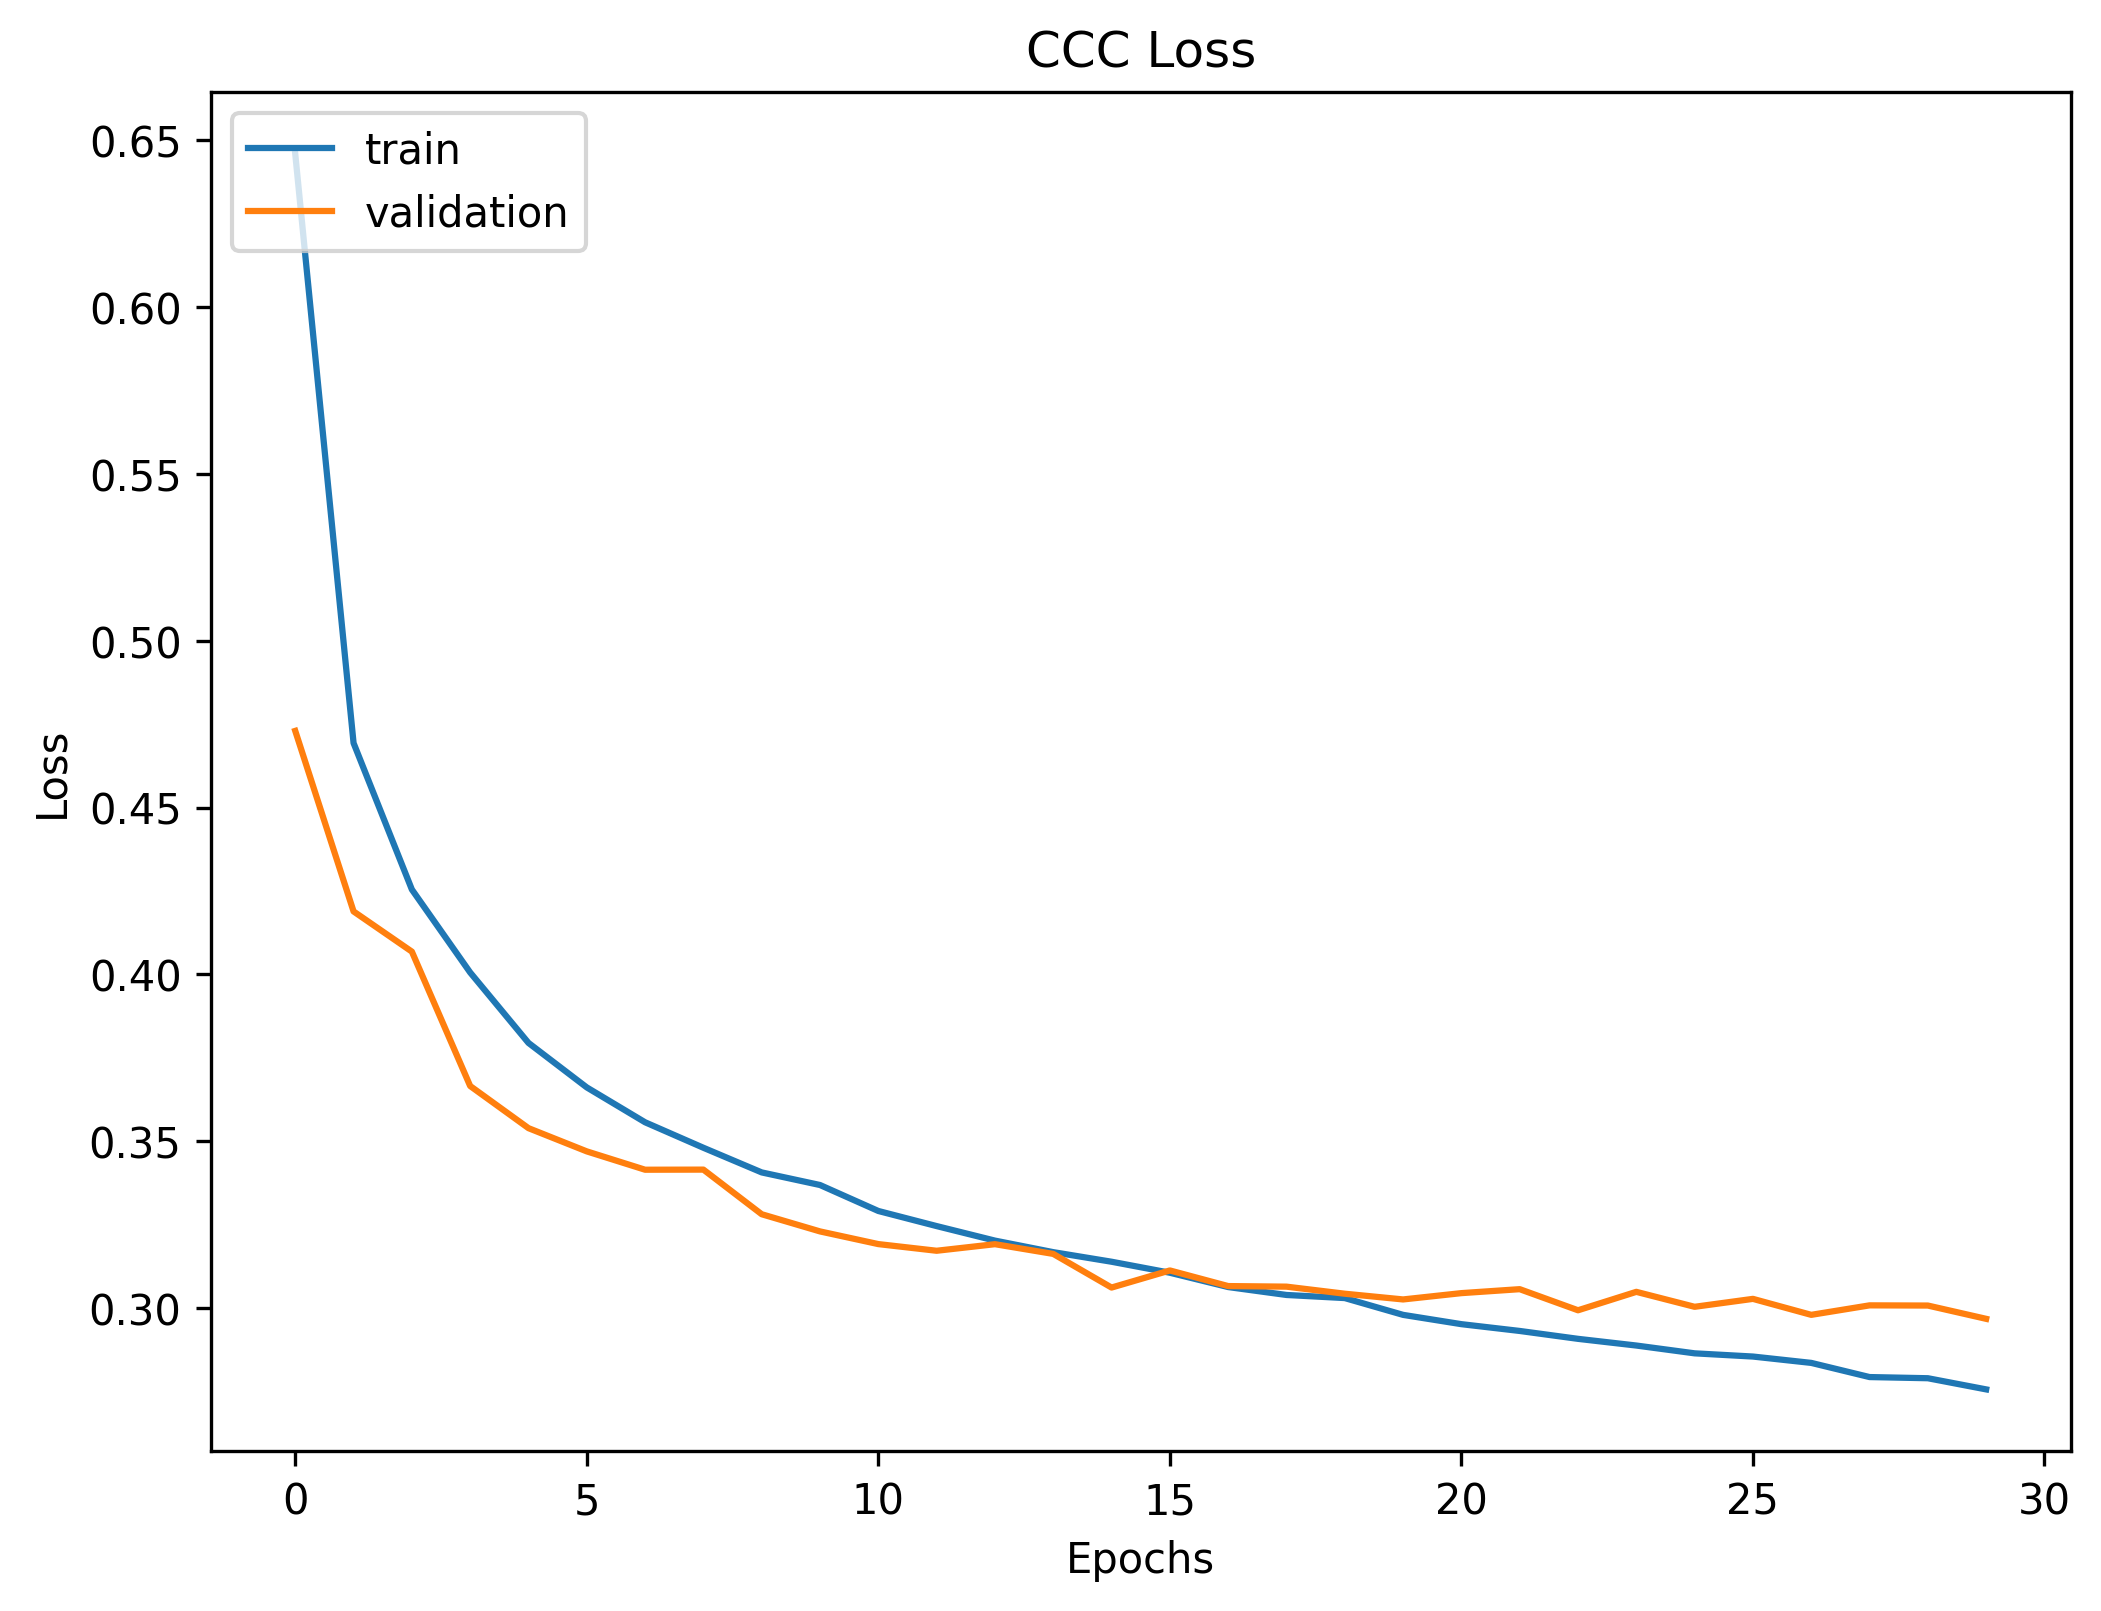

In [ ]:
###Results for the model
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(8,6))
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('CCC Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

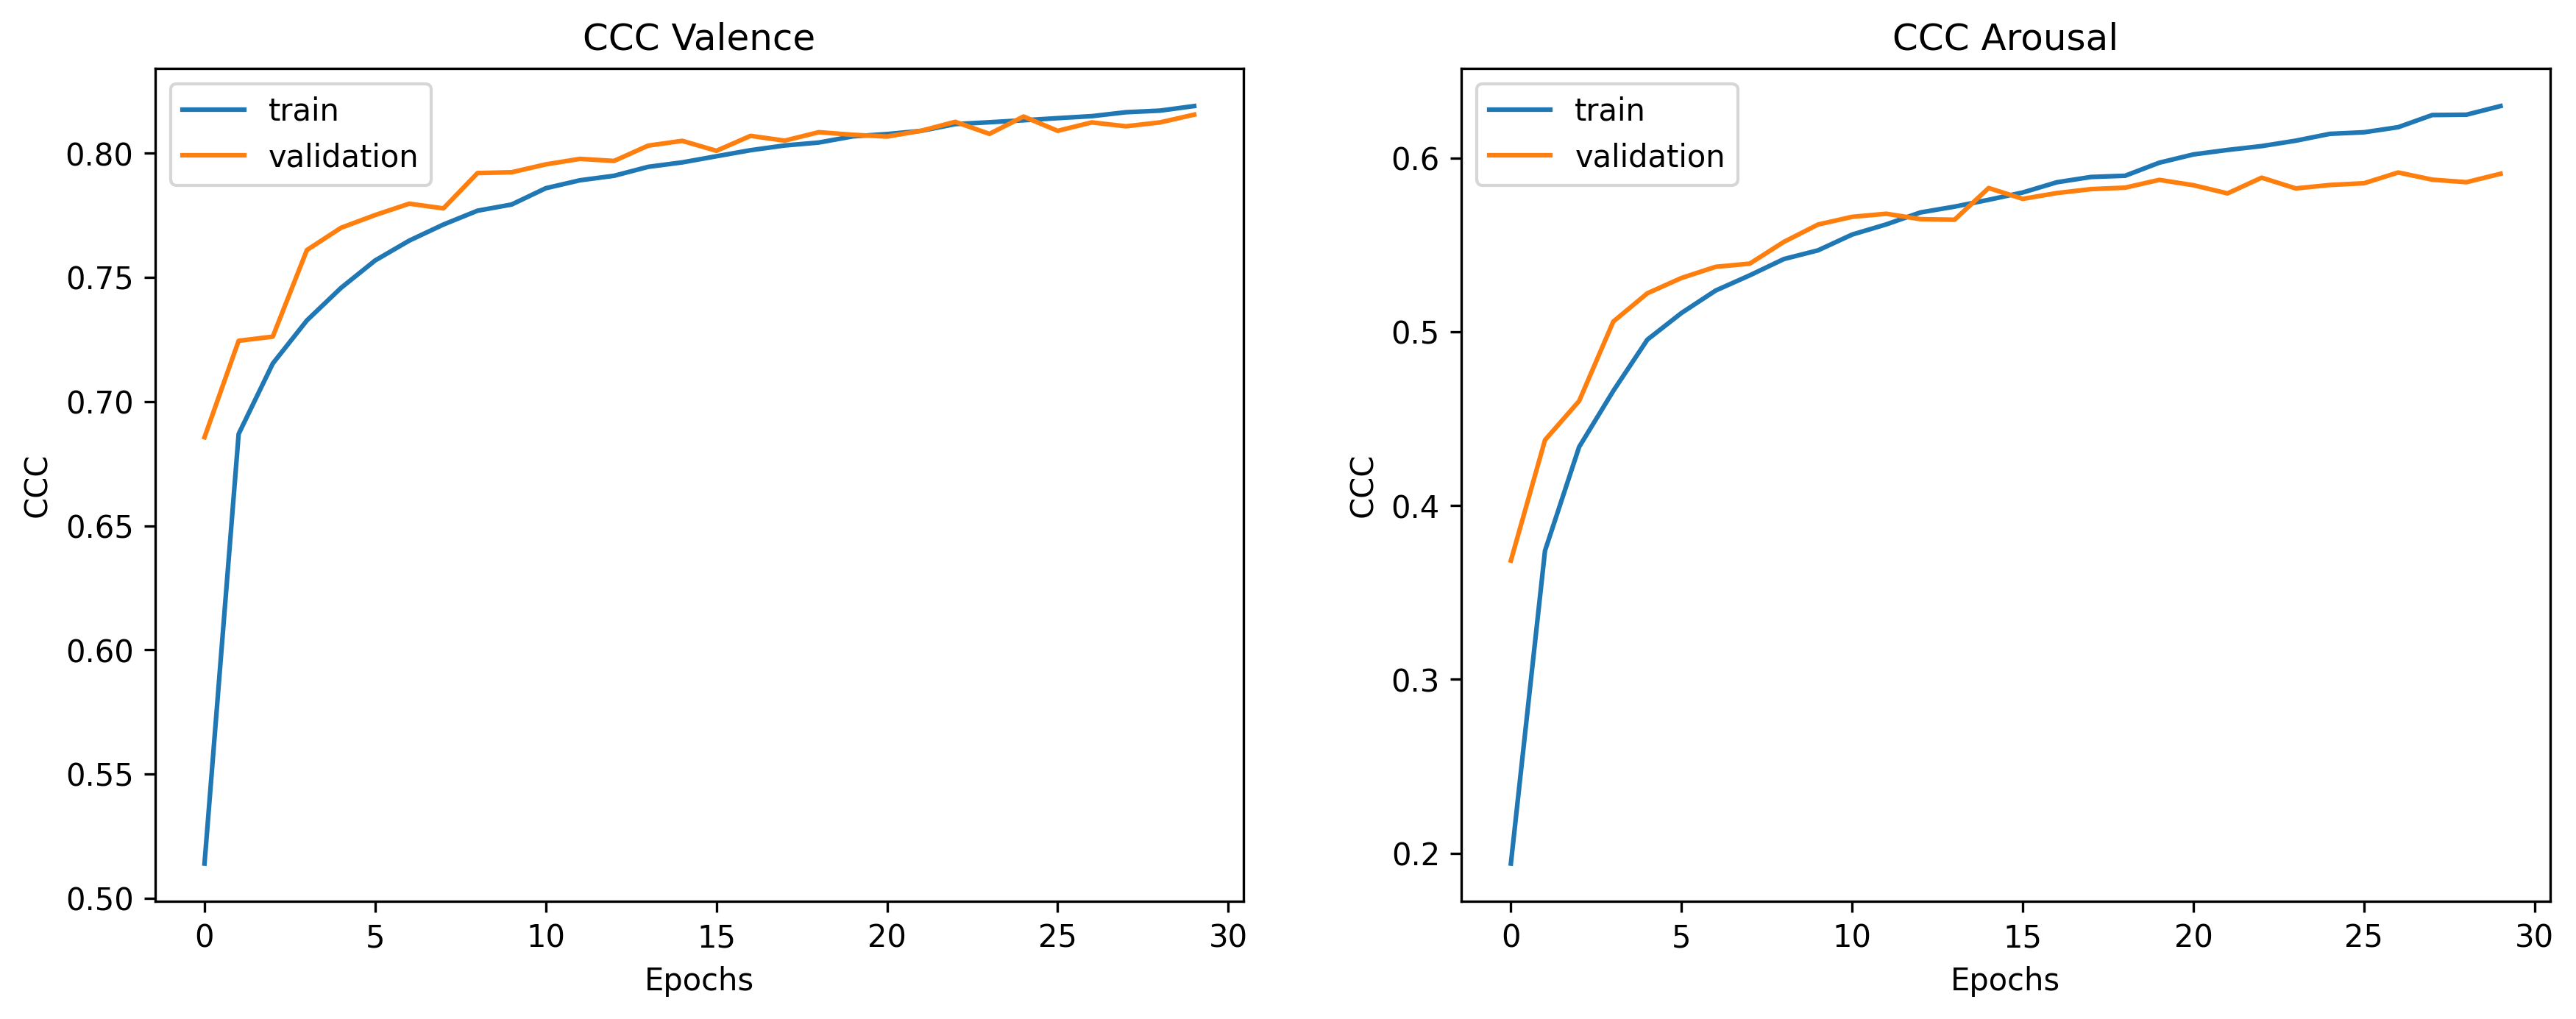

In [ ]:
###Results for the model
### PLOTTING OF CCC SCORE
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)

plt.plot(model_hist.history['ccc_v'])
plt.plot(model_hist.history['val_ccc_v'])
plt.title('CCC Valence')
plt.xlabel('Epochs')
plt.ylabel('CCC')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(model_hist.history['ccc_a'])
plt.plot(model_hist.history['val_ccc_a'])
plt.title('CCC Arousal')
plt.xlabel('Epochs')
plt.ylabel('CCC')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()